# Probability and Basic Statistics

### Descriptor: Skill Level
1. Able to select an appropriate probability analysis based on nature of the data and business knowledge.
2. Able to understand and apply advanced probability methods, such as Bayes Theorem, random number generation, central limit theorem, etc.
3. Able to choose the correct hypothesis testing and confidence interval approaches for a given business problem.
4. Able to define and perform estimation using techniques such as maximum likelihood estimation (MLE) and least squares.


## 1. Appropriate Probability Analysis


### Oil Reservers Uncertainty

3 different methods in estimating reserves
1. Volumetric method
2. Decline Curve Analysis (DCA)
3. Numerical reservoir simulation

P10, P50 and P90 numbers are quoted to capture the uncertainties

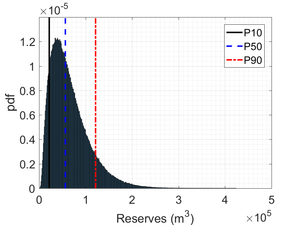

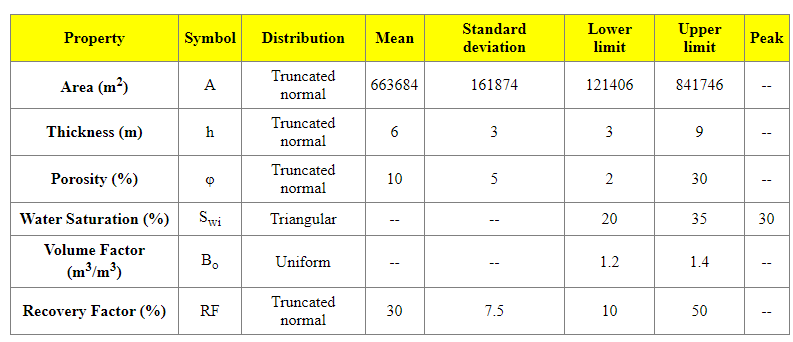
http://large.stanford.edu/courses/2016/ph240/almajid1/

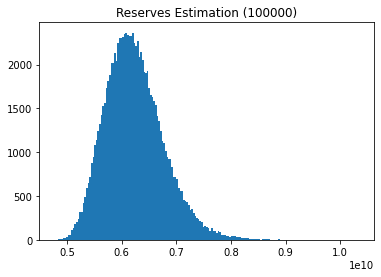

P10 5593632308.739286
P50 6189097722.278191
P90 6932547256.726247


In [101]:
import random
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

def volumetric_method(
    area_bound: tuple,
    thickness_bound: tuple, 
    porosity_bound: tuple,
    water_saturation_bound: tuple,
    volume_factor_bound: tuple,
    recovery_factor_bound: tuple,
    random_state=None
):
    random.seed(random_state)
    a = truncnorm.rvs(area_bound[0], area_bound[1], loc=area_bound[2], scale=area_bound[3],
                      random_state=random_state)
    h = truncnorm.rvs(thickness_bound[0], thickness_bound[1], loc=thickness_bound[2], scale=thickness_bound[3],
                      random_state=random_state)
    poro = truncnorm.rvs(porosity_bound[0], porosity_bound[1], loc=porosity_bound[2], scale=porosity_bound[3],
                      random_state=random_state)
    sw = random.triangular(water_saturation_bound[0], water_saturation_bound[1], water_saturation_bound[2])
    bo = random.uniform(volume_factor_bound[0], volume_factor_bound[1])
    rf = truncnorm.rvs(
        recovery_factor_bound[0],
        recovery_factor_bound[1],
        loc=recovery_factor_bound[2],
        scale=recovery_factor_bound[3],
        random_state=random_state)
    reserves = a * h * poro * (1 - sw) / bo * rf
    return reserves

n_try = 100000
reserves = np.empty(0)
for i in range(n_try):
    result = volumetric_method(
        area_bound=(121406, 841746, 663684, 161874),
        thickness_bound=(3, 9, 6, 3), 
        porosity_bound=(.2, .3, .1, .05),
        water_saturation_bound=(.2, .35, .3),
        volume_factor_bound=(1.2, 1.4),
        recovery_factor_bound=(.1, .5, .3, .075),
#         random_state=123
    )
    reserves = np.append(reserves, result)
    
a = np.hstack(reserves)
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title(f"Reserves Estimation ({n_try})")
plt.show()
p10, p50, p90 = np.percentile(reserves, [10, 50, 90])
print('P10', p10)
print('P50', p50)
print('P90', p90)

## 2. Advanced Probability Methods


### Bayes Theorem
Describes the probability of an event based on prior knowledge. 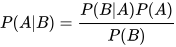
- P(A) or P(B) also known as prior probability
- P(A|B) or P(B|A) a.k.a. posterior probability

### Random Number Generation (RNG)
True randomness is based on natural occuring entropy: atmospheric noise, thermal noise etc

Hardware (HRNG)
- Based on physical/ mechanical action: dice rolling, coin flipping etc.

Pseudo (PRNG)
- Based on initial value which is called seed. May reproduced based on the seed number.

In [1]:
import random
# random.seed(1)
print("randint ", random.randint(1, 100))
print("randrange ", random.randrange(100))
print("random ", random.random())

randint  56
randrange  37
random  0.8107767882309888


### Central Limit Theorem
CLT states that the distribution of $\bar{x}$ is approximately normal, $\bar{x}$ ~ $(\mu, \frac{\sigma}{\sqrt{n}})$. This approximation gets better when the sample size increase.

## 3. Hypothesis Testing and Confidence Interval

Implemented in drift analysis for Proxy Well Model (PWM) where we check whether data drift and/ or model drift occur.

In [8]:
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataDriftTab, NumTargetDriftTab, RegressionPerformanceTab
from evidently.pipeline.column_mapping import ColumnMapping
from evidently.model_profile import Profile
from evidently.model_profile.sections import DataDriftProfileSection, NumTargetDriftProfileSection
from evidently.model_profile.sections import RegressionPerformanceProfileSection
import json
import numpy as np

In [37]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing(as_frame=True)
housing_data = data.frame
housing_data.rename(columns={'MedHouseVal': 'target'}, inplace=True)
housing_data['prediction'] = housing_data['target'].values + np.random.normal(0, 10, housing_data.shape[0])
reference_data = housing_data.sample(n=100, replace=False, random_state=1).reset_index()
current_data = housing_data.sample(n=100, replace=False, random_state=2).reset_index()

In [38]:
dashboards = dict(
    data_drift=Dashboard(tabs=[DataDriftTab()]),
    target_drift=Dashboard(tabs=[NumTargetDriftTab()]),
    model_drift=Dashboard(tabs=[RegressionPerformanceTab(verbose_level=0)]),
)

profiles = dict(
    data_drift=Profile([DataDriftProfileSection()]),
    target_drift=Profile([NumTargetDriftProfileSection()]),
    model_drift=Profile([RegressionPerformanceProfileSection()]),
)

count = 0
for d, dashboard in dashboards.items():
    count += 1
    try:
        dashboard.calculate(reference_data, current_data)
        dashboard.save(f'B3_{count}_{d}.html')
    except Exception as e:
        print(e)


## 4. Maximum Likelihood Estimation (MLE)
What is MLE? Estimating the parameters of a probability distribution which maximize the likelihood function.
Why MLE? To make inference about the population.
Where being implemented?

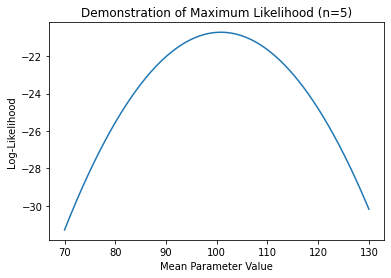

MLE [-33884.32702256 -17051.66487012]


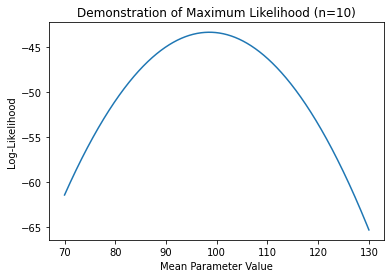

MLE [98.54280731 17.86354872]


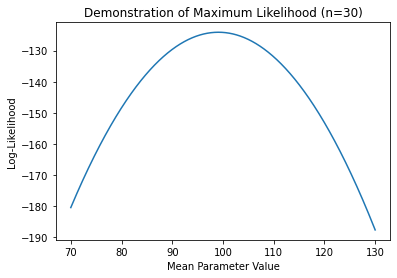

MLE [99.10090689 15.13671454]


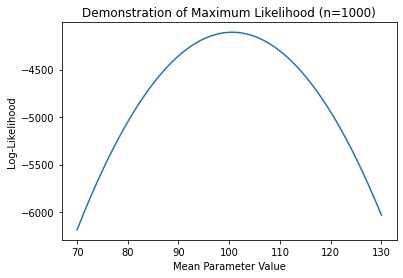

MLE [100.58219351  14.715064  ]


In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

def likelihood(params, data):
    return norm.logpdf(data, loc=params[0], scale=params[1]).sum()

def neglikelihood(params, data):
    return -1 * likelihood(params, data)

n = [5, 10, 30, 1000]
init_mu = 100
init_sigma = 15
for i in n:
    data = norm.rvs(loc=init_mu, scale=init_sigma, size=i, random_state=1)
    x = np.linspace(70, 130, 1000)
    y = [likelihood([val, 15], data) for val in x]
    
    # Estimating mu and sigma based on the sample data points using MLE approach
    result = minimize(neglikelihood, [50, 10], args=(data))

    plt.plot(x, y)
    plt.title(f'Demonstration of Maximum Likelihood (n={i})')
    plt.ylabel('Log-Likelihood')
    plt.xlabel('Mean Parameter Value')
    plt.show()
    print(f'MLE {result.x}')